Based on demonstration of maximum-likelihood reconstruction with SIRF

# A notebook to get you used to some of the syntax of SIRF and PyTorch and introduce the ideas behind the sensitivity image and why we'd want to change it

# Initial set-up

In [1]:
from odl_funcs.ellipses import EllipsesDataset
from odl_funcs.misc import *

In [2]:
# pip install -U scikit-learn

In [3]:
from sklearn.metrics import mean_squared_error

In [4]:
#%% make sure figures appears inline and animations works
%matplotlib inline

# Setup the working directory for the notebook
import notebook_setup
from sirf_exercises import cd_to_working_dir
cd_to_working_dir('PET', 'ML_reconstruction')

In [5]:
#%% Initial imports etc
import numpy as np
import scipy.stats
from scipy import ndimage
from scipy.ndimage import affine_transform
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import sys
import shutil
from numba import njit, prange
#%% Read in images
import brainweb
from tqdm import tqdm
#import scipy
#from scipy import optimize
import sirf.STIR as pet
import sirf.Reg as reg
from sirf.Utilities import examples_data_path
from sirf_exercises import exercises_data_path
pet.set_verbosity(0)

# increase dpi of matplotlib figures
plt.rcParams['figure.dpi'] = 200

# define the directory with input files for this notebook
data_path = os.path.join(examples_data_path('PET'), 'thorax_single_slice')

/home/sirfuser/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [6]:
# set-up redirection of STIR messages to files
msg_red = pet.MessageRedirector('info.txt', 'warnings.txt', 'errors.txt')

In [7]:
#%% some handy function definitions
def plot_2d_image(idx,vol,title,clims=None,cmap="viridis"):
    """Customized version of subplot to plot 2D image"""
    plt.subplot(*idx)
    plt.imshow(vol,cmap=cmap)
    if not clims is None:
        plt.clim(clims)
    plt.colorbar(shrink=.4)
    plt.title(title)
    plt.axis("off")

def make_positive(image_array):
    """truncate any negatives to zero"""
    image_array[image_array<0] = 0
    return image_array

def make_cylindrical_FOV(image):
    """truncate to cylindrical FOV"""
    filter = pet.TruncateToCylinderProcessor()
    filter.apply(image)

## Create some simulated data from ground-truth images
First, we'll create some data to work with. We'll use a simulated image and attenuation map to create some data to work with as well as our sensitivity maps
We'll use brainweb's data base to simulate brain FDG-18 images here. Don't worry too much about this next part

In [8]:
fname, url= sorted(brainweb.utils.LINKS.items())[0]
files = brainweb.get_file(fname, url, ".")
data = brainweb.load_file(fname)

brainweb.seed(1337)
# brainweb.seed(1330)

for f in tqdm([fname], desc="mMR ground truths", unit="subject"):
    vol = brainweb.get_mmr_fromfile(f, petNoise=1, t1Noise=0.75, t2Noise=0.75, petSigma=1, t1Sigma=1, t2Sigma=1)

FDG_arr  = vol['PET']
T1_arr   = vol['T1']
uMap_arr = vol['uMap']

mMR ground truths: 100%|██████████| 1/1 [00:00<00:00,  2.83subject/s]


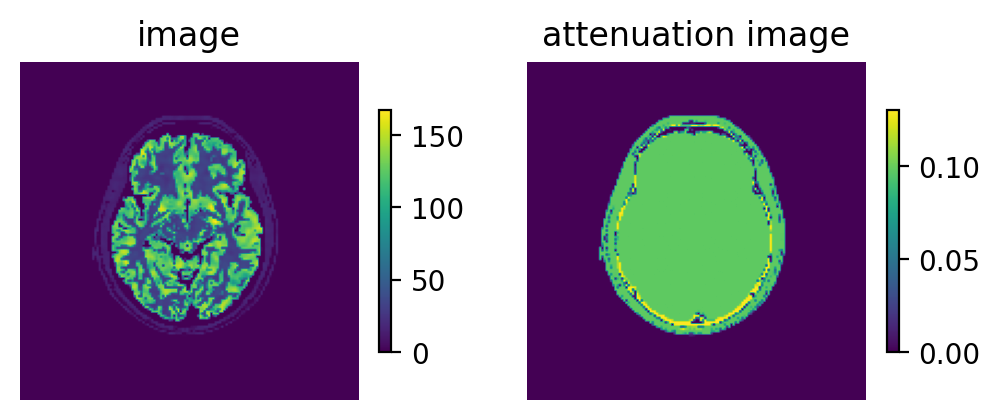

In [9]:
def crop(img, cropx, cropy):
    z,y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[:, starty:starty+cropy,startx:startx+cropx]

# function to zoom out and crop the brainweb images
fdg_zoomed = crop(ndimage.zoom(FDG_arr, 1, order=1), 155, 155) # crop and zoom image
fdg_zoomed = np.expand_dims(fdg_zoomed[50,:,:], axis = 0) # expand for pseudo 3D

umap_zoomed = crop(ndimage.zoom(uMap_arr, 1, order=1), 155, 155) # crop and zoom image
umap_zoomed = np.expand_dims(umap_zoomed[50,:,:], axis = 0) # expand for pseudo 3D

image_template = pet.ImageData(os.path.join(data_path, 'emission.hv'))
image = image_template.clone().fill(fdg_zoomed)
attn_image = image_template.clone().fill(umap_zoomed)

template = pet.AcquisitionData(os.path.join(data_path, 'template_sinogram.hs'))

# This is what our simulated images look like
plt.figure()
plot_2d_image([1,2,1], image.as_array()[0,:], "image")
plot_2d_image([1,2,2], attn_image.as_array()[0,:], "attenuation image")
plt.show()

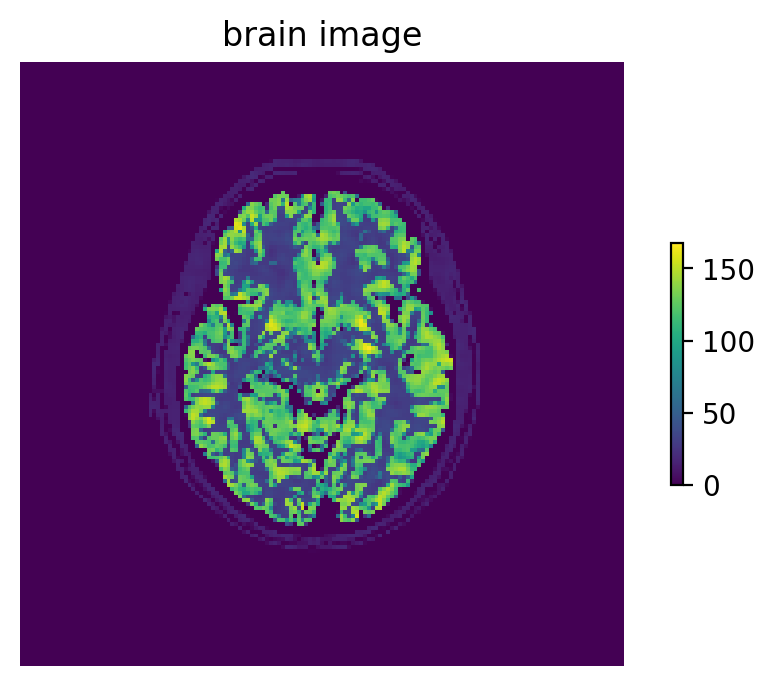

In [10]:
plot_2d_image([1,1,1], image.as_array()[0,:], "brain image")
plt.savefig('/home/sirfuser/devel/share_data/brain.png')

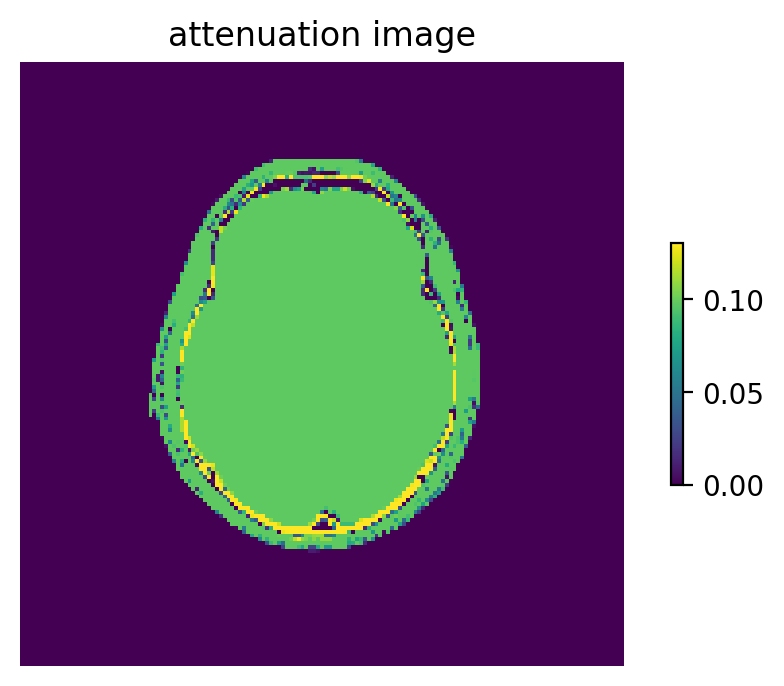

In [11]:
plot_2d_image([1,1,1],  attn_image.as_array()[0,:], "attenuation image")
plt.savefig('/home/sirfuser/devel/share_data/atten.png')

In [12]:
#%% save max for future displays
cmax = image.max()*.6

We are going to start creating our detector model. A PET (or SPECT or CT or...) acquisition process is characterised by a system matrix, $\mathcal{A}$, as well as additive contributions consisting of scatter and random coincidences (PET specific):
$$f = \mathcal{A}u + s + r $$
Wwhere $f$ is our data, $u$ is our image and $s,r$ are our additive componatnts. We will only model the system matrix in this notebook, but SIRF can handle additive components as well.

Now, our system model is itself comprised of a number of different operations. We will concentrate on three of these: the geometrical matrix, $\mathcal{G}$, which maps voxels to LORs, a diagonal attenuation matrix, $D(\tilde{a})$, and a resampling operation to account for patient motion $\mathcal{R}$. This gives us:
$$ \mathcal{A} \approx \mathcal{G} \hat{D}(a) \mathcal{R} =  D(a) \mathcal{G} \mathcal{R}$$
where 
$$  D(a) = \exp(-\mathcal{G}\mu) $$
are the attenuation factors in the projection space and $\mu$ are attenuation factors per voxel

We'll start with our geometric projection matrix. This gets us from our image space to our projection space (look up the radon transform, if you're interested) by taking line integrals through our field of view along each line of response. We'll use a SIRF class called a `RayTracingMatrix` to do this.

In [13]:
# create acquisition model matrix (this uses something called ray tracing, which you can ignore for this example)
# This is a 3-D (or in our case 2-D) Radon Transform matrix
acq_model_matrix  = pet.RayTracingMatrix()
# we will increase the number of rays used for every Line-of-Response (LOR) used in the calculation
acq_model_matrix.set_num_tangential_LORs(20)
# We can now create the acquisition model using this matrix
acq_model = pet.AcquisitionModelUsingMatrix(acq_model_matrix)

And we have the geometrical part of our acquisition model $\mathcal{A} \approx \mathcal{G} $ 

Now, for this next part, we'll concentrate on the diagonal attenuation matrix in our system model.
$$ \mathcal{A} \approx  D(a) \mathcal{G} \mathcal{R} $$

So what is this attenuation matrix? It's the effect that the attenuation of the patient has on the likelihood of a photon being detected along an LOR. SIRF has a way of working this out for us automatically. We use an `AcquisitionSensitivityModel` and input our attenuation image to give us the attenuation correction factors for each LOR

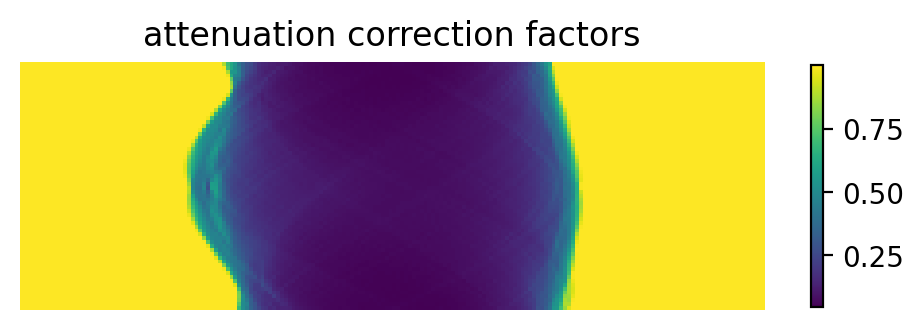

In [14]:
acq_model_for_attn = pet.AcquisitionModelUsingRayTracingMatrix() # this saves us a line of code but is the same as in the previous cell=
asm_attn = pet.AcquisitionSensitivityModel(attn_image, acq_model_for_attn)
asm_attn.set_up(template)
# we can now find the attenuation sensitivity factors for each LOR by forward projecting a uniform image.
# We can set the value of this uniform image to be our detector efficiency. For now, let's just use 1.
attn_factors = asm_attn.forward(template.get_uniform_copy(1))
plt.figure()

plot_2d_image([1,1,1], attn_factors.as_array()[0,0,:], "attenuation correction factors")

This "image" looks a bit funny. Hopefully you've done some reading into this already, but this is what's know as a sinogram (because of the sinusoidal shape) and consists of 2D views of the object from different angles stacked on top of eachother.

We can add these attnuation correction factors to our Acquistion Model

In [15]:
# add the detector sensitivity (based on the attenuation image) that we made previously
acq_model.set_acquisition_sensitivity(pet.AcquisitionSensitivityModel(attn_factors))
# set-up
acq_model.set_up(template,image)

And we now have $\mathcal{A} \approx {D}(a) \mathcal{G}  $. 

Disregarding rotation, we have a simple model of our detector and can use it to get an expected value of how our image should look in projection space, $E[y]$

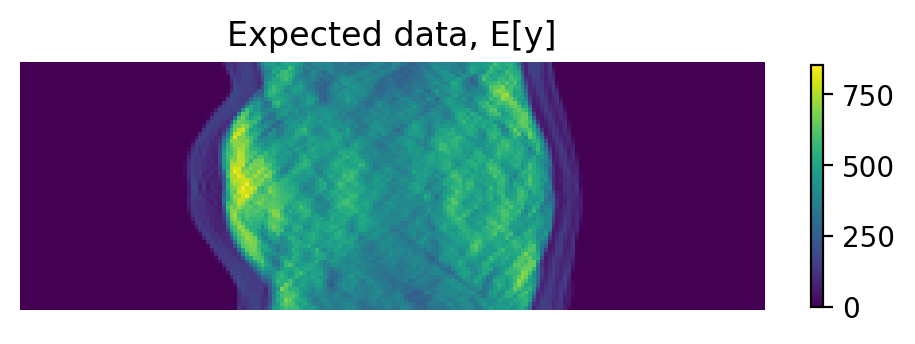

In [16]:
#%% simulate some data using forward projection
acquired_data=acq_model.forward(image)
plot_2d_image([1,1,1], acquired_data.as_array()[0,0,:], "Expected data, E[y]")

In order to simulate some basic simulated acquired data to use in this notebook, we can add some poisson noise

In [17]:
def add_noise(proj_data,noise_factor = 0.1, seed = 50):
    """Add Poission noise to acquisition data."""
    proj_data_arr = proj_data.as_array() / noise_factor
    # Data should be >=0 anyway, but add abs just to be safe
    np.random.seed(seed)
    noisy_proj_data_arr = np.random.poisson(proj_data_arr).astype('float32');
    noisy_proj_data = proj_data.clone()
    noisy_proj_data.fill(noisy_proj_data_arr*noise_factor);
    return noisy_proj_data

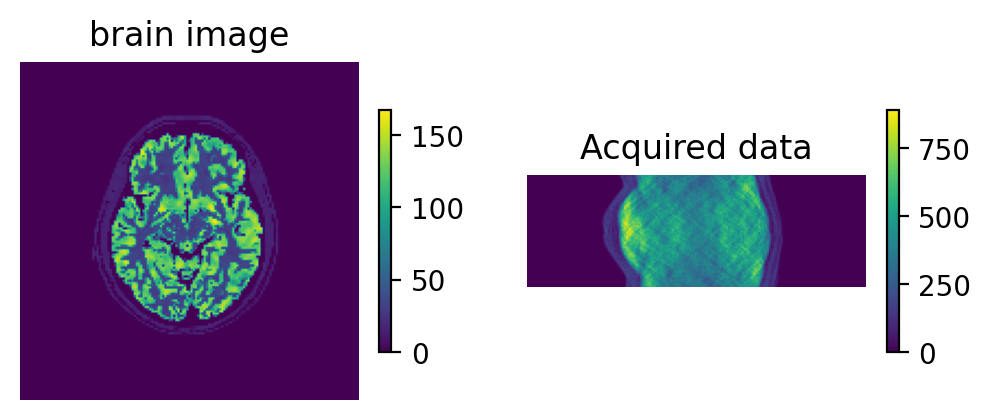

In [18]:
noisy_data = add_noise(acquired_data,1)
plot_2d_image([1,2,1], image.as_array()[0,:], "brain image")
plot_2d_image([1,2,2], noisy_data.as_array()[0,0,:], "Acquired data")
plt.savefig('/home/sirfuser/devel/share_data/sino.png')

OK and we have some simulated data. We have added poisson noise because of photon counting statistics where we either detect a count or we don't. 

### So, How does this all relate to the sensitivity image?

Our sensitivity image is (approximately) how likely a particular voxel is to be detected. In order to calculate this, we can use our acquistion model $\mathcal{A}$, but in reverse:
$$ \mathcal{S}  = \mathcal{A}^T \cdot \mathbf{1} \approx \mathcal{G}^T D(a)^T \cdot \mathbf{1}$$

This sensitivity image will look like the backprojection (including attenutation) of a uniform sinogram of ones.

So what does that look like for our patient?

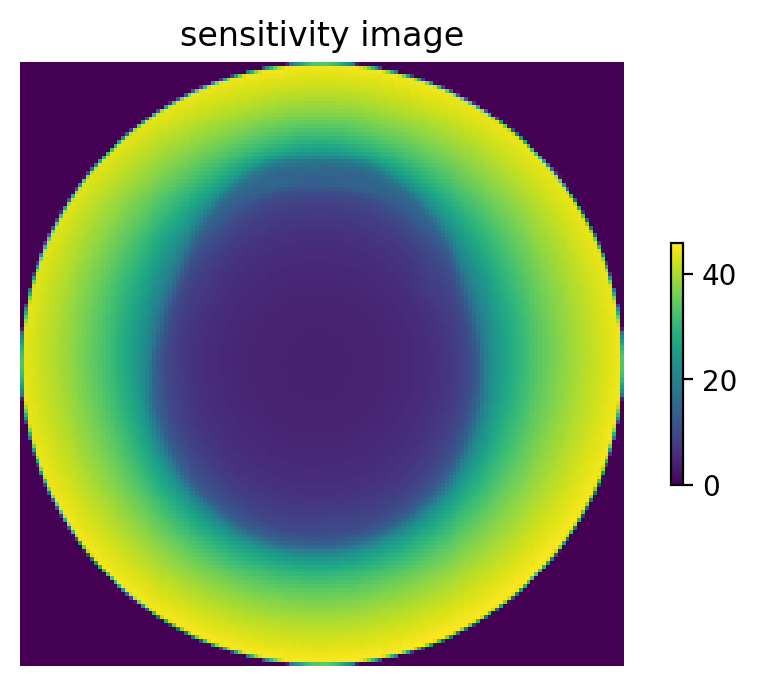

In [19]:
sens_image = acq_model.backward(template.get_uniform_copy(1))
plot_2d_image([1,1,1], sens_image.as_array()[0,:], "sensitivity image")
plt.savefig('/home/sirfuser/devel/share_data/sensitivity_image.png')

Now, lets have a look at what can happen to our sensitivity image (or attenuation factors) if we have a misaligned object. This is our $\mathcal{R}$. The sensitivity image will be

$$ \tilde{\mathcal{S}} = \mathcal{A}^T \cdot \mathbf{1} \approx \mathcal{R}^T \mathcal{G}^T D(\tilde{a}) \cdot \mathbf{1}$$

We'll first create a function to apply an affine transform to our image

In [20]:
def affine_transform_2D(theta, tx, ty, sx, sy, image_arr):
    ''' create a random affine transformation for 2D images '''
    # create the transformation matrix
    transformation_matrix = np.array([[sx*np.cos(theta), -sy*np.sin(theta), tx],
                                        [sx*np.sin(theta),  sy*np.cos(theta), ty],
                                        [0, 0, 1]])

    # apply the transformation
    image_arr_transformed = affine_transform(image_arr, transformation_matrix, order=1)
    return image_arr_transformed

Now let's apply this to out attenuation image and see what happens

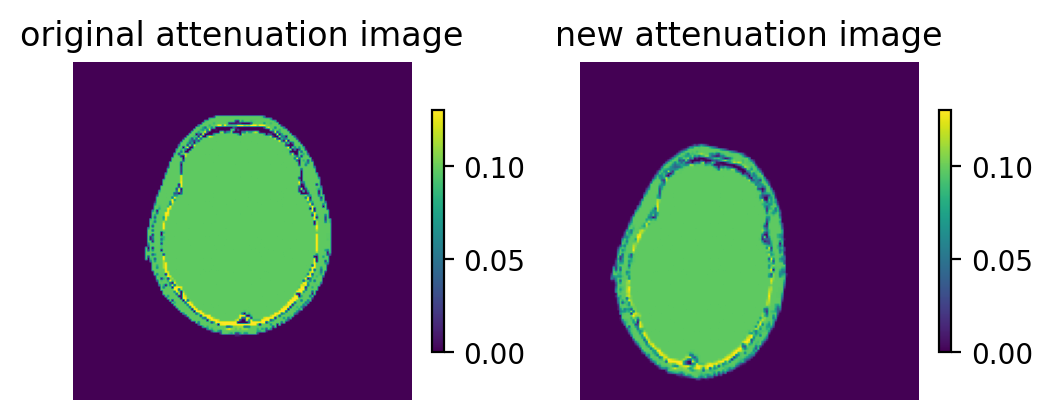

In [97]:
vol_attn = attn_image.as_array()

# apply a random affine transformation using np.random
# theta = np.random.uniform(-np.pi/32, np.pi/32)
# tx, ty = np.random.uniform(-1, 1), np.random.uniform(-1, 1)
# sx, sy = np.random.uniform(0.98, 1.08), np.random.uniform(0.98, 1.08)

# More motion
theta = np.random.uniform(-np.pi/8, np.pi/8)    # Increased from pi/32 to pi/8
tx, ty = np.random.uniform(-3, 3), np.random.uniform(-3, 3)  # Increased range from (-1, 1) to (-3, 3)
sx, sy = np.random.uniform(0.90, 1.15), np.random.uniform(0.90, 1.15)  # Adjusted range from (0.98, 1.08) to (0.90, 1.15)


vol_transformed = affine_transform_2D(theta, tx, ty, sx, sy, vol_attn[0,:])

vol_transformed = np.expand_dims(vol_transformed, axis=0)

attn_image_transform = attn_image.clone().fill(vol_transformed)

vol_im = image.as_array()
vol_transformed = affine_transform_2D(theta, tx, ty, sx, sy, vol_im[0,:])
vol_transformed = np.expand_dims(vol_transformed, axis=0)

image_transform = image.clone().fill(vol_transformed)

plt.figure()
plot_2d_image([1,2,1], attn_image.as_array()[0,:], "original attenuation image")
plot_2d_image([1,2,2], attn_image_transform.as_array()[0,:], "new attenuation image")
plt.savefig('/home/sirfuser/devel/share_data/m1.png')
plt.show()

OK, so we have simulated some (quite large) movement. Let's look at how this will effect the sensitivity image

In [82]:
import time

# Record the start time
start_time = time.time()



acq_model_for_attn_transform = pet.AcquisitionModelUsingRayTracingMatrix() # this saves us a line of code but is the same as in the previous cell
# We now create the sensitivity model using the acquisition model and the attenuation image
asm_attn_transform = pet.AcquisitionSensitivityModel(attn_image_transform, acq_model_for_attn_transform)
asm_attn_transform.set_up(template)
attn_factors_transform = asm_attn_transform.forward(template.get_uniform_copy(1))
# And then add the detector sensitivity (based on the attenuation image) that we made previously
acq_model_transform = pet.AcquisitionModelUsingRayTracingMatrix()
acq_model_transform.set_acquisition_sensitivity(asm_attn_transform)
# set-up
acq_model_transform.set_up(template,image)
sens_image_transform = acq_model_transform.backward(template.get_uniform_copy(1))


# Record the end time
end_time = time.time()

# Calculate the runtime
runtime = end_time - start_time
print(f"Code runtime: {runtime} seconds")

Code runtime: 0.1730349063873291 seconds


In [87]:
import time

# Number of iterations
num_iterations = 100
total_runtime = 0

for _ in range(num_iterations):
    # Record the start time
    start_time = time.time()


    acq_model_for_attn_transform = pet.AcquisitionModelUsingRayTracingMatrix()
    asm_attn_transform = pet.AcquisitionSensitivityModel(attn_image_transform, acq_model_for_attn_transform)
    asm_attn_transform.set_up(template)
    attn_factors_transform = asm_attn_transform.forward(template.get_uniform_copy(1))
    acq_model_transform = pet.AcquisitionModelUsingRayTracingMatrix()
    acq_model_transform.set_acquisition_sensitivity(asm_attn_transform)
    acq_model_transform.set_up(template, image)
    sens_image_transform = acq_model_transform.backward(template.get_uniform_copy(1))

    # Record the end time
    end_time = time.time()

    # Calculate the runtime and add to total
    runtime = end_time - start_time
    total_runtime += runtime

# Calculate the average runtime
average_runtime = total_runtime / num_iterations
print(f"Average code runtime over {num_iterations} iterations: {average_runtime} seconds")


Average code runtime over 100 iterations: 0.1803058695793152 seconds


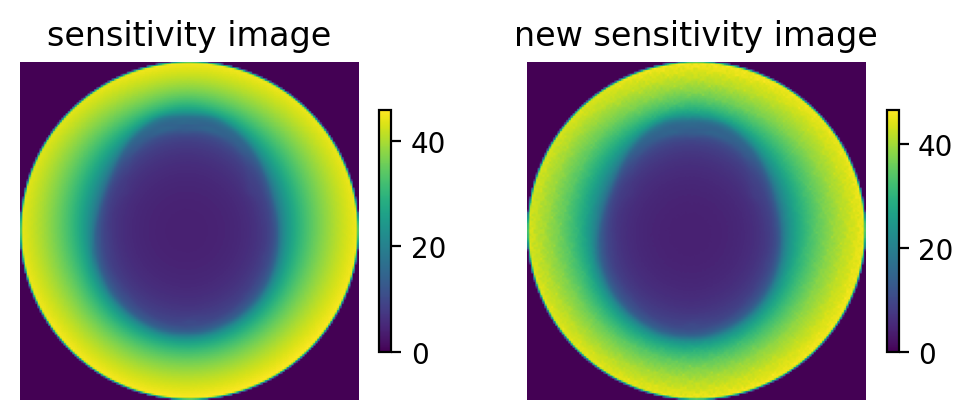

In [23]:
plt.figure()
plot_2d_image([1,2,1], sens_image.as_array()[0,:], "sensitivity image")
plot_2d_image([1,2,2], sens_image_transform.as_array()[0,:], "new sensitivity image")
plt.savefig('/home/sirfuser/devel/share_data/m2.png')
plt.show()

Now let's compare a few reconstructions with our old and new sensitivity images. We'll use a home-made OSEM to highlight this. This is an iterative algorithm that requires the sensitivity image to be recalculated for every iteration. This is a slow process and why using a neural network could be very beneficial

Firstly, let's write a quick function to deal with zero division errors outsiude of the FoV. We're using a parallel programming functionality called numba. This can be ignored. We're just setting pixels outside the FoV to zero

In [24]:
@njit
def division(arr1, arr2):
    tmp  = np.zeros_like(arr1).flatten()
    for i in prange(tmp.size):
        if arr2.flatten()[i] != 0:
            tmp[i] = arr1.flatten()[i]/arr2.flatten()[i]
        else:
            tmp[i] = 0
    return tmp.reshape(arr1.shape)

Next we'll create a function to perform a step of the Maximum Likelihood Expectation Maximisation. This is a reconstruction algorithm (don;t worry too much about where it comes from) with an update equation:
$$ u_{n+1} = \frac{u_n}{\mathcal{A}^T \cdot \mathbf{1}} \mathcal{A}^T \frac{y}{\mathcal{A} u_n + s + r} = \frac{u_n}{\mathcal{R}^T \mathcal{G}^T D(\tilde{a})\cdot \mathbf{1}} \mathcal{R}^T \mathcal{G}^TD(\tilde{a}) \frac{y}{D(a) \mathcal{G}\mathcal{R} u_n + s + r} = \frac{u_n}{\tilde{\mathcal{S}} } \mathcal{R}^T \mathcal{G}^T \frac{y}{\mathcal{G}\mathcal{R} u_n + s + r}$$
where, as in Rahmim et al (2004) we have cancelled the attenuation matrix in the forward and backward steps because the transpose of a diagonal matrix is the same diagonal matrix. Now, we're not trying to reconstruct the intial image (at the moment), but the transformed image, $\tilde{u}$, so we have a MLEM step that will look like
$$ \tilde{u}_{n+1} = \frac{\tilde{u}_n}{\tilde{\mathcal{S}} } \mathcal{G}^T \frac{y}{\mathcal{G}\tilde{u}_n + s + r}$$ 

This algorithm does the following:
1. We find the ratio of our measured data and our expected data $\frac{y}{E[y]}$
2. we back project this ratio into our image domain $A^T$
3. we multiply by the previous image iterate divided by our sensitivity image $\frac{u_n}{A^T \mathbf{1}} $
This algorithm is used regularly in clinic (most often in its subset form OSEM)

In [25]:
# This function performs a single MLEM update
def MLEM_step(input_image, acq_model, acquired_data, sensitivity_image):
    # forward projection
    forward_projected_data = acq_model.forward(input_image)
    # divide acquired data by forward projected data
    ratio = acquired_data.divide(forward_projected_data)
    # back projection
    back_projected_data = acq_model.backward(ratio)
    # divide by sensitivity image
    back_projected_data.fill(division(back_projected_data.as_array(), sensitivity_image.as_array()))
    # update input image
    output_image = input_image*back_projected_data
    return output_image


## create initial image

We'll start with a uniform image, cropped to only fill the field of view of the scanner

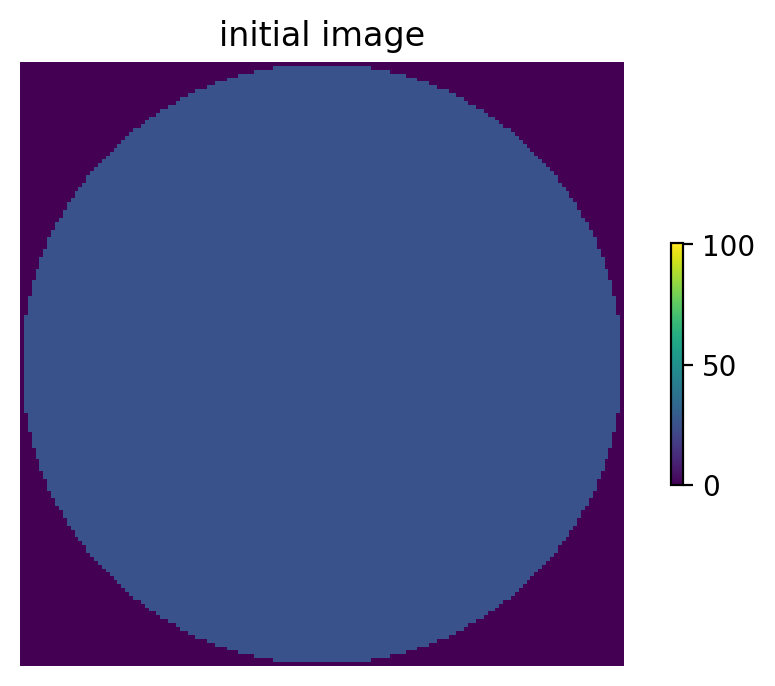

In [26]:
initial_image=image.get_uniform_copy(cmax / 4)
make_cylindrical_FOV(initial_image)
# display
im_slice = initial_image.dimensions()[0] // 2
plt.figure()
plot_2d_image([1,1,1],initial_image.as_array()[im_slice,:,:], 'initial image',[0,cmax])

In order to track how closely our estimate fits the data, we create something called an objective function. We are working with Poisson noise and so we need a data fidelity function that takes this into account. Here we use the poisson log likelihood (this comes from Poisson probability and Bayes theorem - look it up)
$$ \mathcal{D}_{PLL} = y \ln(E[y]) - E[y] $$

In [27]:
obj_fun = pet.make_Poisson_loglikelihood(noisy_data)
obj_fun.set_acquisition_model(acq_model)
obj_fun.set_acquisition_data(noisy_data)
obj_fun.set_up(image)

As we no longer need attenuation in our acquisition model, we'll use a bog standard discrete random transform operator to do our forward and back projections

In [28]:
radon_transform = pet.AcquisitionModelUsingRayTracingMatrix()
radon_transform.set_up(template, image)

Now let's do a reconstruction. First with our original, un-transformed, image

In [29]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values = [obj_fun.value(current_image)]

# create an ndarray to store the images at every sub-iteration
all_osem_images = np.ndarray(shape=(num_iters + 1,) + current_image.dimensions())
all_osem_images[0,:,:,:] = current_image.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image = MLEM_step(current_image, radon_transform, acquired_data, sens_image)
    # store results
    obj_fun_value = obj_fun.value(current_image)
    osem_objective_function_values.append(obj_fun_value)
    all_osem_images[i,:,:,:] =  current_image.as_array()

How did we do?

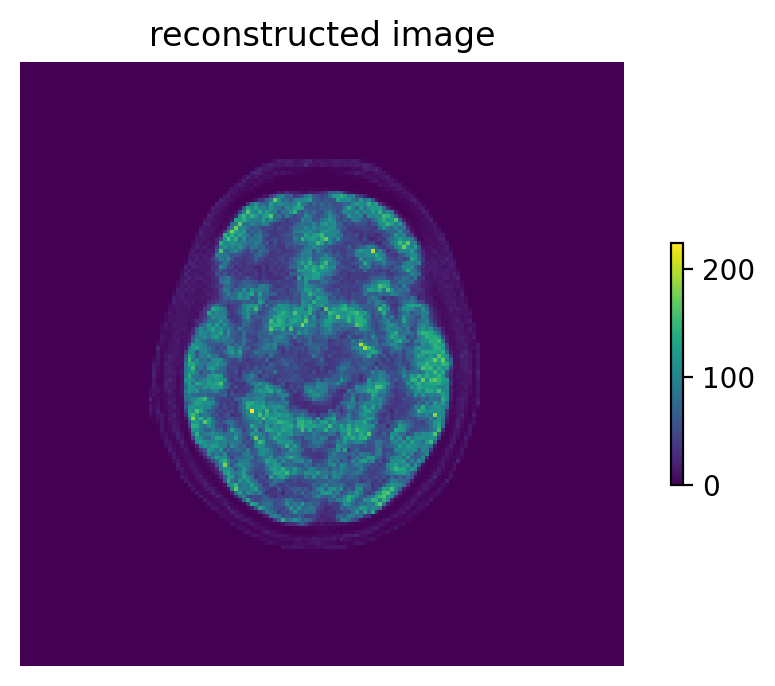

In [30]:
plot_2d_image([1,1,1], all_osem_images[-1][0,:], "reconstructed image")

## Make some plots with these results

Let's see what's going on during the reconstruction by plotting a few of the iterates along with the update and the difference between the image estimate and the ground truth

In [31]:
#%% define a function for plotting images and the updates
def plot_progress(all_images, title, ground_truth, subiterations = [], max = cmax):
    ground_truth_array = ground_truth.as_array()
    if len(subiterations) == 0:
        num_subiters = all_images[0].shape[0] - 1
        subiterations = range(1, num_subiters + 1)
    num_rows = len(all_images)

    for i in subiterations:
        plt.figure()
        for r in range(num_rows):
            plot_2d_image([num_rows,3,3 * r + 1],
                          all_images[r][i,im_slice,:,:],'%s at %d' % (title[r], i), [0,max])
            plot_2d_image([num_rows,3,3*r+2],
                          all_images[r][i,im_slice,:,:]-all_images[r][i - 1,im_slice,:,:],'update',[-max*.05,max*.05], cmap='seismic')
            plot_2d_image([num_rows,3,3*r+3],
                          all_images[r][i,im_slice,:,:]-ground_truth_array[im_slice,:,:],'error',[-max*.5,max*.5], cmap='seismic')
        plt.show()

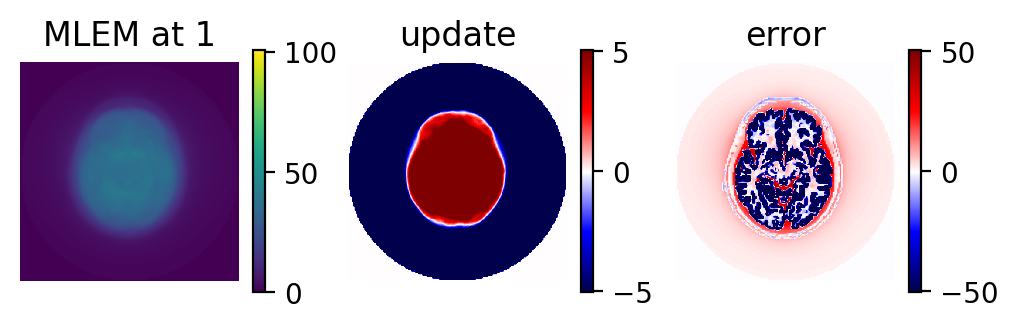

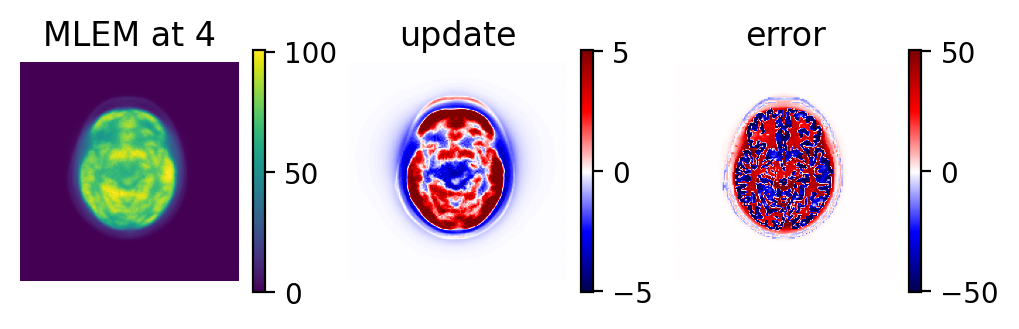

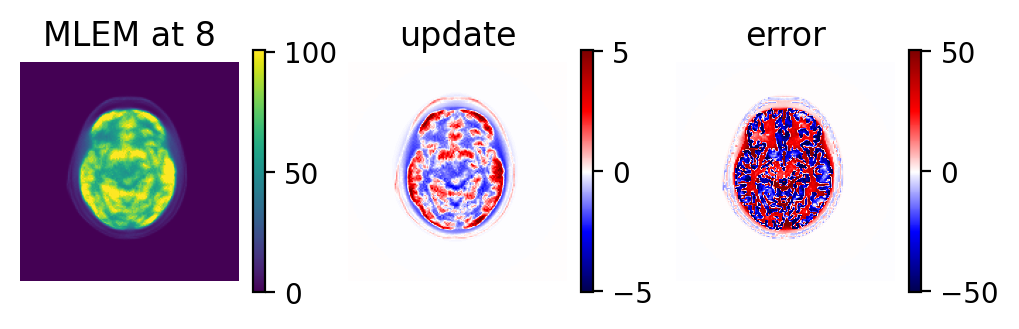

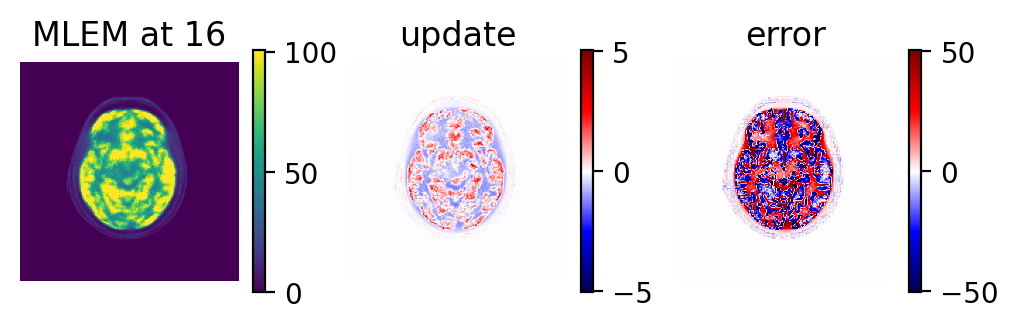

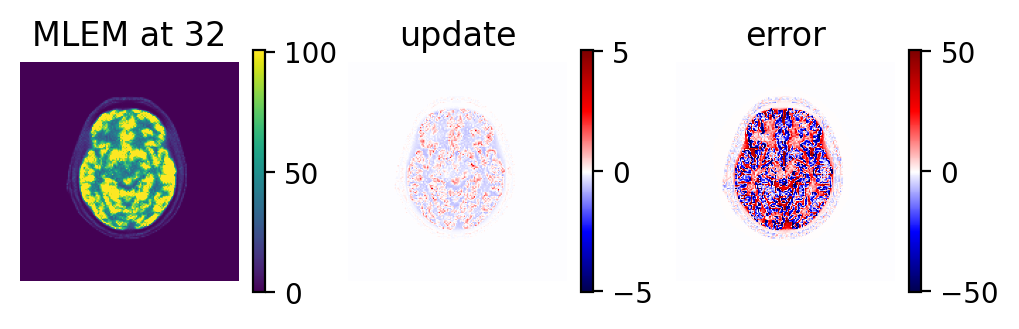

<Figure size 1200x800 with 0 Axes>

In [32]:
#%% now call this function to see how we went along
# note that in the notebook interface, this might create a box with a vertical slider
subiterations = (1,4,8,16,32)
# close all "open" images as otherwise we will get warnings (the notebook interface keeps them "open" somehow)
plt.close('all')    
plot_progress([all_osem_images], ['MLEM'], image, subiterations)
plt.savefig('/home/sirfuser/devel/share_data/mlem.png')

OK. so let's now compare this to a reconstruction with the offset image, but with the original sensitivity image. We'll then compare this to a reconstruction with the correct sensitivity image

In [33]:
noisy_data_transform = add_noise(acq_model_transform.forward(image_transform),1) # new noisy data

In [34]:
obj_fun_transform = pet.make_Poisson_loglikelihood(noisy_data_transform)
obj_fun_transform.set_acquisition_model(acq_model_transform)
obj_fun_transform.set_acquisition_data(noisy_data_transform)
obj_fun_transform.set_up(image_transform)

Using the incorrect sensitivity, $S = \mathcal{G}^T D(a) \cdot 1$

In [35]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_transform = [obj_fun.value(current_image)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_transform = np.ndarray(shape=(num_iters + 1,) + current_image.dimensions())
all_osem_images_transform[0,:,:,:] = current_image.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image = MLEM_step(current_image, radon_transform, noisy_data_transform, sens_image)
    # store results
    obj_fun_value = obj_fun_transform.value(current_image)
    osem_objective_function_values_transform.append(obj_fun_value)
    all_osem_images_transform[i,:,:,:] =  current_image.as_array()

And now using the correct sensitivity, $\tilde{S} = \mathcal{R}^T \mathcal{G}^T D(\tilde{a})$

In [36]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_transform_corr = [obj_fun.value(current_image)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_transform_corr = np.ndarray(shape=(num_iters + 1,) + current_image.dimensions())
all_osem_images_transform_corr[0,:,:,:] = current_image.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image = MLEM_step(current_image, radon_transform, noisy_data_transform, sens_image_transform)
    # store results
    obj_fun_value = obj_fun_transform.value(current_image)
    osem_objective_function_values_transform_corr.append(obj_fun_value)
    all_osem_images_transform_corr[i,:,:,:] =  current_image.as_array()

Let's see what difference a correct sensitivity made

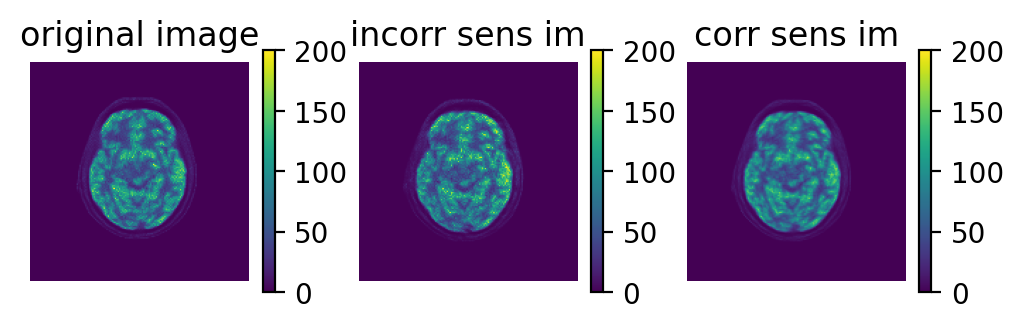

In [37]:
plot_2d_image([1,3,1], all_osem_images[-1][0,:], "original image", clims = [0,200])
plot_2d_image([1,3,2], all_osem_images_transform[-1][0,:], "incorr sens im", clims = [0,200])
plot_2d_image([1,3,3], all_osem_images_transform_corr[-1][0,:], "corr sens im", clims = [0,200])

This has shown us that there can be a large deviation in reconstructed image if the sensitivity image is incorrect. So how can we fix this? One method is to `gate` our acquisition into groups of timepoint with similar attenuation maps (i.e patient positions). We can then calculate a sensitivity image for all these timepoints. However, this could lead to long calculation times.

We could therefore use a neural network to output a the required change in a sensitivity image based on the change in an attenuation image.

In [38]:
# Import a file that can generate the shepp logan phantom
from odl_funcs.ellipses import EllipsesDataset
# Import standard extra packages
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.optim as optim

mini_batch = 10
from sirf.Utilities import examples_data_path


In [39]:
# pip install torchvision

In [40]:
# Import a file that can generate the shepp logan phantom
from odl_funcs.ellipses import EllipsesDataset
# Import standard extra packages
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.optim as optim

mini_batch = 10
from sirf.Utilities import examples_data_path


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

class SimpleCNN(nn.Module):
    """ 
    A CNN for PET sensitivity estimation.
    Consists of 3 convolutional layers with ReLU activation. 
    Kernel sizes are 15x15, 9x9, 5x5, 3x3, 3x3, 7x7, 15x15, 3x3, 3x3 with padding 
    The idea of this is to have a large kernel size at the beginning to capture
    the large motion, and then gradually reduce the kernel size to capture the
    smaller motion.
    The kernel sizes then increases again to provide an edge filtering effect on a blurry image
    A ReLU activation is used after each convolutional layer.
    Input:
        2 images (sensitivity with no motion and attenuation correction map)
    Output:
        1 image (sensitivity with motion)
    """

    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 16, 15, padding=7)
        self.conv2 = nn.Conv2d(16, 32, 9, padding=4)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 32, 7, padding=3)
        self.conv6 = nn.Conv2d(32, 16, 15, padding=7)
        self.conv7 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv8 = nn.Conv2d(16, 1, 3, padding=1)

    def forward(self, x):
        x[:,1,:,:]=x[:,1,:,:].mul(10)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        return x

In [42]:
mini_batch = 2
train_dataloader = torch.utils.data.DataLoader( \
    EllipsesDataset(radon_transform, attn_image, template, mode="train", n_samples = 16) \
    , batch_size=mini_batch, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader( \
    EllipsesDataset(radon_transform, attn_image, template, mode="valid", n_samples = 4) \
    , batch_size=mini_batch, shuffle=False)


In [43]:
loss_function = nn.MSELoss()
model = SimpleCNN()
# model = UNet()
optimizer = optim.Adam(model.parameters(), lr=0.0000001) # really small learning rate because we should be (almost) at the optimum already

In [44]:
# model.load_state_dict(torch.load("/home/sirfuser/devel/Wei/SIRF-Exercises/notebooks/PET_sensitivity/model_cnn_large.pt", map_location=device))
# model = SimpleCNN()
model.load_state_dict(torch.load("/home/sirfuser/devel/share_data/model_SimpleCNN_10000_2-1.pt", map_location=device))
# model.load_state_dict(torch.load("/home/sirfuser/devel/share_data/U_model_2-1.pth", map_location=device))

model.eval()
model.to(device)

SimpleCNN(
  (conv1): Conv2d(2, 16, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
  (conv2): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv6): Conv2d(32, 16, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
  (conv7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [45]:
train_loss_history = []
valid_loss_history = []

for epoch in range(3): # 3full passes over the data
    for data, validation in zip(train_dataloader, valid_dataloader):  # `data` is a batch of data
        X, y = data  # X is the batch of features, y is the batch of targets.
        model.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        output = model(X.to(device))  # pass in the reshaped batch
        loss = loss_function(output, y.to(device))  # calc and grab the loss value
        train_loss_history.append(loss)
        #valid_loss_history.append(loss_function(net(validation[0].to(device)), validation[1].to(device)))
        loss.backward()  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
    print(loss)  # print loss. We hope loss (a measure of wrong-ness) declines! 

mMR ground truths: 100%|██████████| 1/1 [00:00<00:00,  3.15subject/s]


tensor(6.1385, grad_fn=<MseLossBackward0>)


mMR ground truths: 100%|██████████| 1/1 [00:00<00:00,  3.39subject/s]


tensor(8.9080, grad_fn=<MseLossBackward0>)


mMR ground truths: 100%|██████████| 1/1 [00:00<00:00,  3.38subject/s]


tensor(9.8432, grad_fn=<MseLossBackward0>)


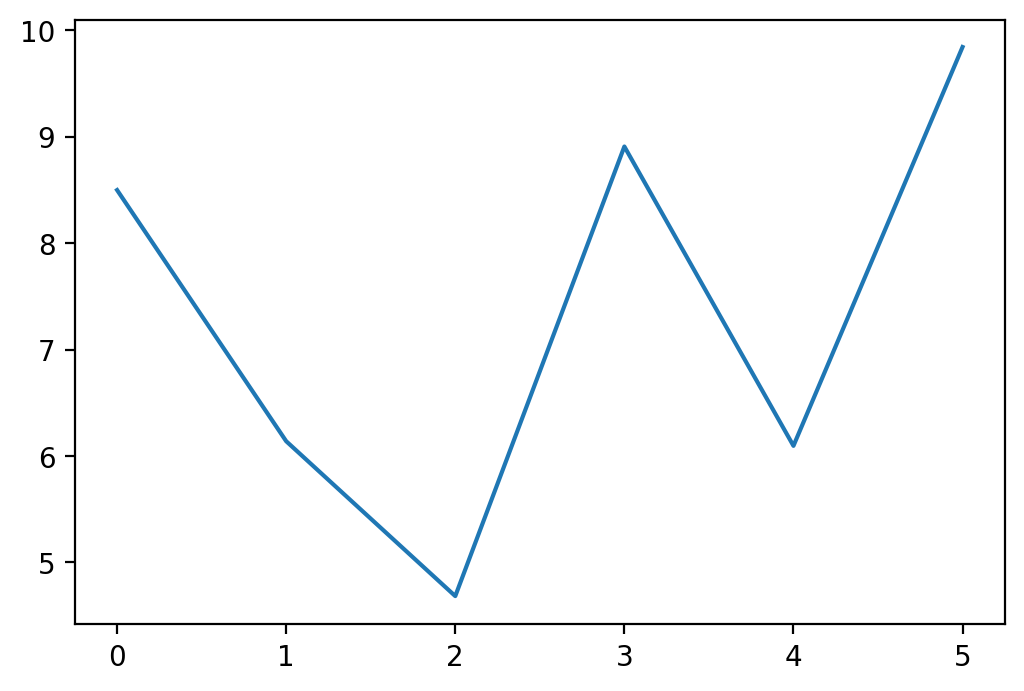

In [46]:
loss_history=[]
for i in train_loss_history:
    loss_history.append(i.item())
plt.plot(loss_history)

This was already converged, which is why you see this flat, noisy line here. The training objective function looked more like this (note we're minimising the objective function for the network - this is just a converntion thing)

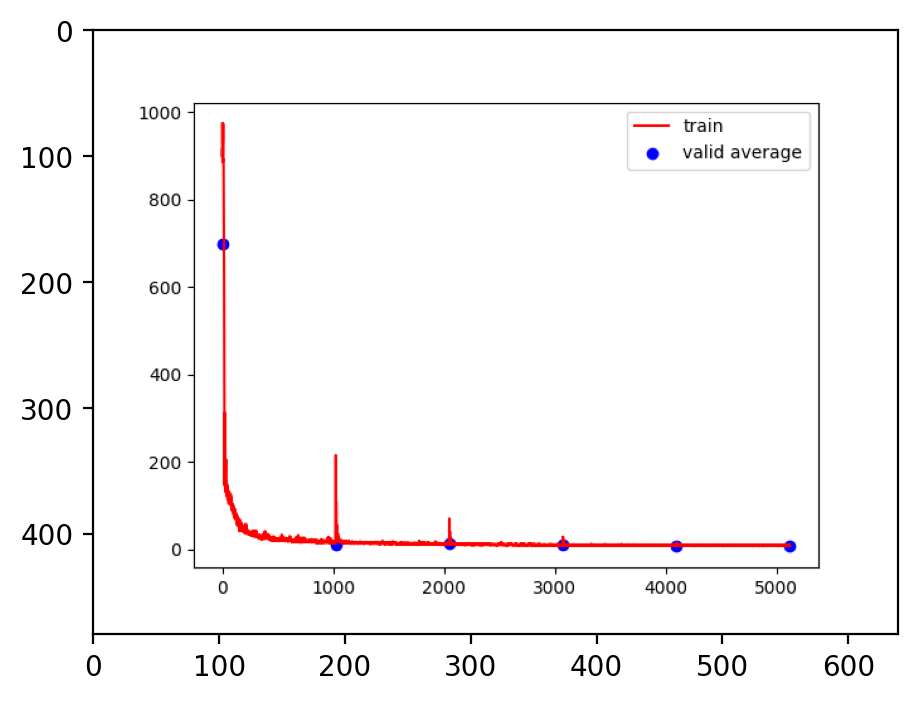

In [47]:
import matplotlib.image as mpimg
img = mpimg.imread('/home/sirfuser/devel/wei/SIRF-Exercises/notebooks/PET_sensitivity/loss_history_CNN_large.png')
imgplot = plt.imshow(img)
plt.show()

In [48]:
input_data = torch.from_numpy(np.squeeze(np.array([sens_image.as_array(), attn_image_transform.as_array()]))).unsqueeze(0)
# input_data = torch.from_numpy(np.squeeze(np.array([sens_image.as_array(), attn_image_transform.as_array(),attn_image.as_array()]))).unsqueeze(0)
input_data = input_data.to(device)

In [49]:
out = model(input_data)

In [50]:
sens_image_NN = sens_image.clone().fill(out.detach().cpu().numpy()[0,:,:,:])

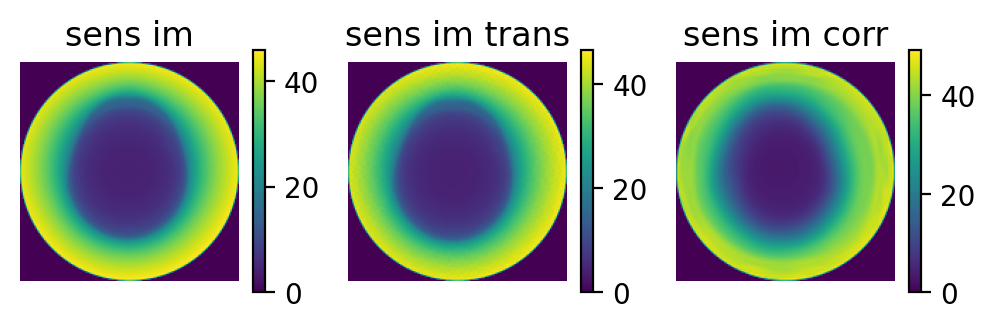

In [51]:
plot_2d_image([1,3,1], sens_image.as_array()[0,:,:], 'sens im', cmap="viridis")
plot_2d_image([1,3,2], sens_image_transform.as_array()[0,:,:], 'sens im trans', cmap="viridis")
plot_2d_image([1,3,3], sens_image_NN.as_array()[0,:,:], 'sens im corr', cmap="viridis")

And that was surprisingly good! There's definitely a lot wrong, but you can se the network was trying to do what we asked - how could we improve this network to more accurately predict out sensitivity image?

Let's see how this looks when we reconstruct it

In [52]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image_NN = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_NN = [obj_fun.value(current_image_NN)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_NN_c = np.ndarray(shape=(num_iters + 1,) + current_image_NN.dimensions())
all_osem_images_NN_c[0,:,:,:] = current_image_NN.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image_NN = MLEM_step(current_image_NN, radon_transform, noisy_data_transform, sens_image_NN)
    # store results
    all_osem_images_NN_c[i,:,:,:] = current_image_NN.as_array()

In [53]:
# plt.imshow(current_image_NN.as_array()[0,:,:])

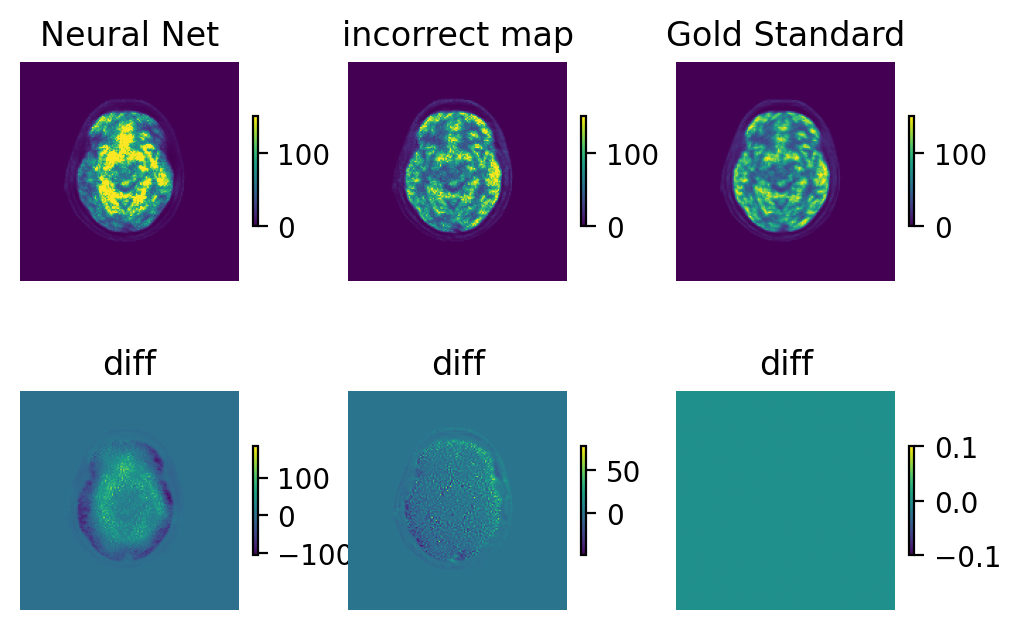

In [54]:
plot_2d_image([2,3,1], all_osem_images_NN_c[-1,0,:,:], 'Neural Net', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,2], all_osem_images_transform[-1,0,:,:], 'incorrect map', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,3], all_osem_images_transform_corr[-1,0,:,:], 'Gold Standard', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,4], all_osem_images_NN_c[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], 'diff', cmap="viridis")
plot_2d_image([2,3,5], all_osem_images_transform[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], 'diff', cmap="viridis")
plot_2d_image([2,3,6], all_osem_images_transform_corr[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], 'diff', cmap="viridis")

# U-net
# 2-1
# sen_orig, ct_moved->sen_moved

In [55]:
import torch
from torch import nn
from torch.nn import functional as F

class Conv_Block(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(Conv_Block, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,3,1,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)


class DownSample(nn.Module):
    def __init__(self,channel):
        super(DownSample, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(channel,channel,3,2,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(channel),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)


class UpSample(nn.Module):
    def __init__(self,channel):
        super(UpSample, self).__init__()
        self.layer=nn.Conv2d(channel,channel//2,1,1)
    def forward(self,x,feature_map):
        up=F.interpolate(x,scale_factor=2,mode='nearest')
        out=self.layer(up)
        return torch.cat((out,feature_map),dim=1)


class UNet(nn.Module):
    def __init__(self,num_classes=1):
        super(UNet, self).__init__()
        self.c1=Conv_Block(2,64)  # change from 3 to 2 input channels
        self.d1=DownSample(64)
        self.c2=Conv_Block(64,128)
        self.d2=DownSample(128)
        self.c3=Conv_Block(128,256)
        self.d3=DownSample(256)
        self.c4=Conv_Block(256,512)
        self.d4=DownSample(512)
        self.c5=Conv_Block(512,1024)
        self.u1=UpSample(1024)
        self.c6=Conv_Block(1024,512)
        self.u2 = UpSample(512)
        self.c7 = Conv_Block(512, 256)
        self.u3 = UpSample(256)
        self.c8 = Conv_Block(256, 128)
        self.u4 = UpSample(128)
        self.c9 = Conv_Block(128, 64)
        self.out=nn.Conv2d(64,num_classes,3,1,1)

    def forward(self,x):
        # pad input tensor so it has shape [batch_size, 2, 160, 160]
        x = F.pad(input=x, pad=(3, 2, 3, 2), mode='constant', value=0)

        R1=self.c1(x)
        R2=self.c2(self.d1(R1))
        R3 = self.c3(self.d2(R2))
        R4 = self.c4(self.d3(R3))
        R5 = self.c5(self.d4(R4))
        O1=self.c6(self.u1(R5,R4))
        O2 = self.c7(self.u2(O1, R3))
        O3 = self.c8(self.u3(O2, R2))
        O4 = self.c9(self.u4(O3, R1))
        output = self.out(O4)

        # Crop the output to match target size
        output_cropped = output[..., 3:-2, 3:-2]
        return output_cropped

In [56]:
model = UNet()
model.load_state_dict(torch.load("/home/sirfuser/devel/share_data/U_model_2-1.pth", map_location=device))
model.eval()
model.to(device)

UNet(
  (c1): Conv_Block(
    (layer): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout2d(p=0.3, inplace=False)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout2d(p=0.3, inplace=False)
      (7): LeakyReLU(negative_slope=0.01)
    )
  )
  (d1): DownSample(
    (layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (c2): Conv_Block(
    (layer): Sequential(
      (0): Conv2d(64, 

In [57]:
input_data = torch.from_numpy(np.squeeze(np.array([sens_image.as_array(), attn_image_transform.as_array()]))).unsqueeze(0)
input_data = input_data.to(device)
out = model(input_data)
sens_image_NN = sens_image.clone().fill(out.detach().cpu().numpy()[0,:,:,:])

In [58]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image_NN = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_NN = [obj_fun.value(current_image_NN)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_NN = np.ndarray(shape=(num_iters + 1,) + current_image_NN.dimensions())
all_osem_images_NN[0,:,:,:] = current_image_NN.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image_NN = MLEM_step(current_image_NN, radon_transform, noisy_data_transform, sens_image_NN)
    # store results
    all_osem_images_NN[i,:,:,:] = current_image_NN.as_array()

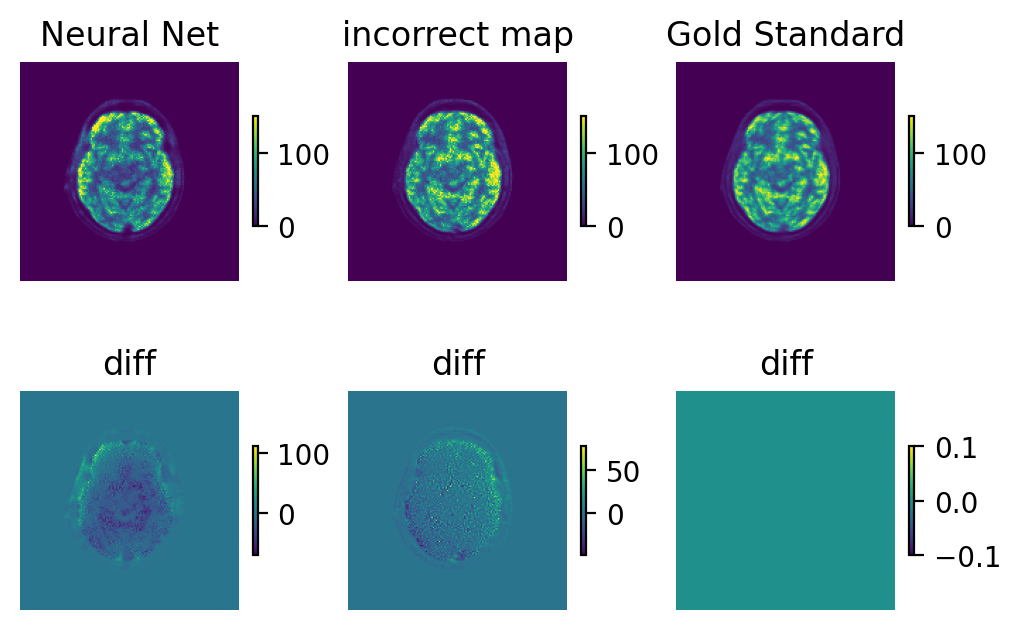

In [59]:
plot_2d_image([2,3,1], all_osem_images_NN[-1,0,:,:], 'Neural Net', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,2], all_osem_images_transform[-1,0,:,:], 'incorrect map', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,3], all_osem_images_transform_corr[-1,0,:,:], 'Gold Standard', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,4], all_osem_images_NN[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], 'diff', cmap="viridis")
plot_2d_image([2,3,5], all_osem_images_transform[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], 'diff', cmap="viridis")
plot_2d_image([2,3,6], all_osem_images_transform_corr[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], 'diff', cmap="viridis")

# 3-2
# sen_orig, ct_orig-ct_moved->sen_orig-sen_moved

In [60]:
model.load_state_dict(torch.load("/home/sirfuser/devel/share_data/U_model_3-2.pth", map_location=device))
model.eval()
model.to(device)

UNet(
  (c1): Conv_Block(
    (layer): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout2d(p=0.3, inplace=False)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout2d(p=0.3, inplace=False)
      (7): LeakyReLU(negative_slope=0.01)
    )
  )
  (d1): DownSample(
    (layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (c2): Conv_Block(
    (layer): Sequential(
      (0): Conv2d(64, 

In [61]:
input_data = torch.from_numpy(np.squeeze(np.array([sens_image.as_array(),attn_image.as_array()-attn_image_transform.as_array()]))).unsqueeze(0)
input_data = input_data.to(device)

In [62]:
out = model(input_data)
sens_image_NN_2 = sens_image.clone().fill(out.detach().cpu().numpy()[0,:,:,:])
# sens_image_NN = sens_image_NN + sens_image_transform.as_array()[0,:,:]
 


In [63]:
sens_image_NN_2 = sens_image_NN_2 + sens_image_transform

In [64]:
# plt.imshow(sens_image_NN.as_array()[0,:,:])

In [65]:
# plt.imshow(sens_image_transform.as_array()[0,:,:]+ sens_image_NN.as_array()[0,:,:])

In [66]:
np.shape(sens_image_NN)

(1, 155, 155)

In [67]:
np.shape(sens_image_transform.as_array())

(1, 155, 155)

In [68]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image_NN = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_NN = [obj_fun.value(current_image_NN)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_NN_2 = np.ndarray(shape=(num_iters + 1,) + current_image_NN.dimensions())
all_osem_images_NN_2[0,:,:,:] = current_image_NN.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image_NN = MLEM_step(current_image_NN, radon_transform, noisy_data_transform, sens_image_NN_2)
    # store results
    all_osem_images_NN_2[i,:,:,:] = current_image_NN.as_array()

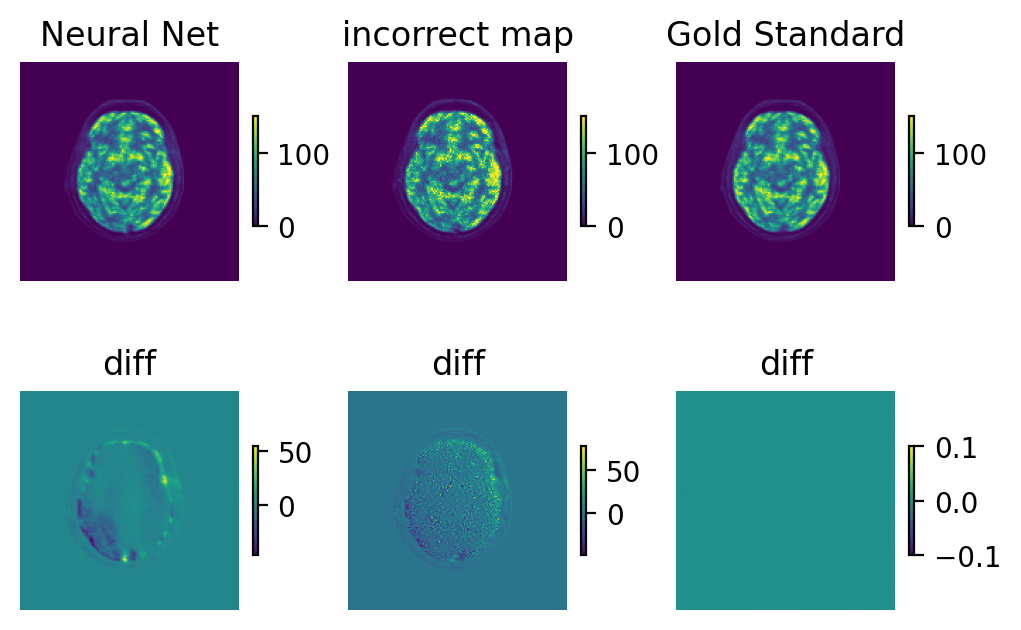

In [69]:
plot_2d_image([2,3,1], all_osem_images_NN_2[-1,0,:,:], 'Neural Net', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,2], all_osem_images_transform[-1,0,:,:], 'incorrect map', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,3], all_osem_images_transform_corr[-1,0,:,:], 'Gold Standard', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,4], all_osem_images_NN_2[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], 'diff', cmap="viridis")
plot_2d_image([2,3,5], all_osem_images_transform[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], 'diff', cmap="viridis")
plot_2d_image([2,3,6], all_osem_images_transform_corr[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], 'diff', cmap="viridis")

# 3 ->1

# sen_orig, ct_orig, ct_moved->sen_moved


In [70]:
import torch
from torch import nn
from torch.nn import functional as F

class Conv_Block(nn.Module):
    def __init__(self,in_channel,out_channel):
        super(Conv_Block, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(in_channel,out_channel,3,1,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU(),
            nn.Conv2d(out_channel, out_channel, 3, 1, 1, padding_mode='reflect', bias=False),
            nn.BatchNorm2d(out_channel),
            nn.Dropout2d(0.3),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)


class DownSample(nn.Module):
    def __init__(self,channel):
        super(DownSample, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(channel,channel,3,2,1,padding_mode='reflect',bias=False),
            nn.BatchNorm2d(channel),
            nn.LeakyReLU()
        )
    def forward(self,x):
        return self.layer(x)


class UpSample(nn.Module):
    def __init__(self,channel):
        super(UpSample, self).__init__()
        self.layer=nn.Conv2d(channel,channel//2,1,1)
    def forward(self,x,feature_map):
        up=F.interpolate(x,scale_factor=2,mode='nearest')
        out=self.layer(up)
        return torch.cat((out,feature_map),dim=1)


class UNet(nn.Module):
    def __init__(self,num_classes=1):
        super(UNet, self).__init__()
        self.c1=Conv_Block(3,64)  # change from 3 to 2 input channels
        self.d1=DownSample(64)
        self.c2=Conv_Block(64,128)
        self.d2=DownSample(128)
        self.c3=Conv_Block(128,256)
        self.d3=DownSample(256)
        self.c4=Conv_Block(256,512)
        self.d4=DownSample(512)
        self.c5=Conv_Block(512,1024)
        self.u1=UpSample(1024)
        self.c6=Conv_Block(1024,512)
        self.u2 = UpSample(512)
        self.c7 = Conv_Block(512, 256)
        self.u3 = UpSample(256)
        self.c8 = Conv_Block(256, 128)
        self.u4 = UpSample(128)
        self.c9 = Conv_Block(128, 64)
        self.out=nn.Conv2d(64,num_classes,3,1,1)

    def forward(self,x):
        # pad input tensor so it has shape [batch_size, 2, 160, 160]
        x = F.pad(input=x, pad=(3, 2, 3, 2), mode='constant', value=0)

        R1=self.c1(x)
        R2=self.c2(self.d1(R1))
        R3 = self.c3(self.d2(R2))
        R4 = self.c4(self.d3(R3))
        R5 = self.c5(self.d4(R4))
        O1=self.c6(self.u1(R5,R4))
        O2 = self.c7(self.u2(O1, R3))
        O3 = self.c8(self.u3(O2, R2))
        O4 = self.c9(self.u4(O3, R1))
        output = self.out(O4)

        # Crop the output to match target size
        output_cropped = output[..., 3:-2, 3:-2]
        return output_cropped

In [71]:
loss_function = nn.MSELoss()
model = UNet()
optimizer = optim.Adam(model.parameters(), lr=0.0000001) # really small learning rate because we should be (almost) at the optimum already
model.load_state_dict(torch.load("/home/sirfuser/devel/share_data/U_model_3-1.pth", map_location=device))
model.eval()
model.to(device)

UNet(
  (c1): Conv_Block(
    (layer): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout2d(p=0.3, inplace=False)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=reflect)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout2d(p=0.3, inplace=False)
      (7): LeakyReLU(negative_slope=0.01)
    )
  )
  (d1): DownSample(
    (layer): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (c2): Conv_Block(
    (layer): Sequential(
      (0): Conv2d(64, 

In [72]:
input_data = torch.from_numpy(np.squeeze(np.array([sens_image.as_array(), attn_image_transform.as_array(),attn_image.as_array()]))).unsqueeze(0)
input_data = input_data.to(device)

In [73]:
out = model(input_data)
sens_image_NN = sens_image.clone().fill(out.detach().cpu().numpy()[0,:,:,:])

In [74]:
# iterator = iter(valid_dataloader)

# # get a single batch
# data = next(iterator)

# # 3 ->1
# #sen_orig, ct_orig, ct_moved->sen_moved


# X, y = data  # X is the batch of features, y is the batch of targets.
# plot_2d_image([1,4,1], X[0,0,:,:].numpy(), "sen_orig")
# plot_2d_image([1,4,2], X[0,1,:,:].numpy(), "ct_orig")
# plot_2d_image([1,4,3], X[0,2,:,:].numpy(), "ct_moved")
# plot_2d_image([1,4,4], y[0,0,:,:].numpy(), "sen_moved")

In [75]:
#%% run same reconstruction but saving images and objective function values every sub-iteration
num_iters = 32

# create an image object that will be updated during the iterations
current_image_NN = initial_image.clone()

# create an array to store the values of the objective function at every
# sub-iteration (and fill in the first)
osem_objective_function_values_NN = [obj_fun.value(current_image_NN)]

# create an ndarray to store the images at every sub-iteration
all_osem_images_NN_3 = np.ndarray(shape=(num_iters + 1,) + current_image_NN.dimensions())
all_osem_images_NN_3[0,:,:,:] = current_image_NN.as_array()

# do the actual updates
for i in range(1, num_iters+1):
    current_image_NN = MLEM_step(current_image_NN, radon_transform, noisy_data_transform, sens_image_NN)
    # store results
    all_osem_images_NN_3[i,:,:,:] = current_image_NN.as_array()

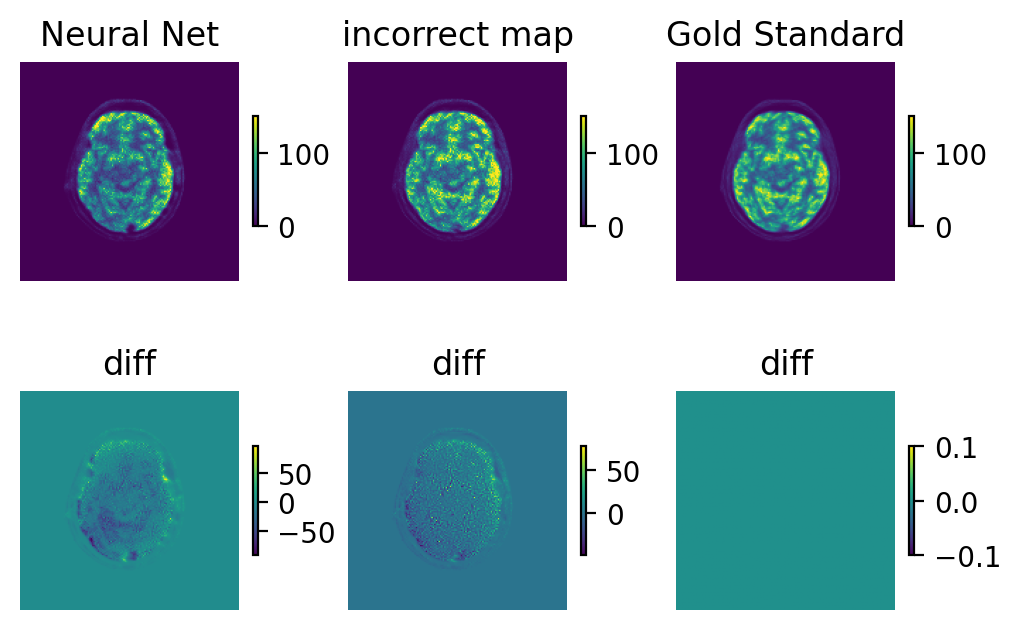

In [76]:
plot_2d_image([2,3,1], all_osem_images_NN_3[-1,0,:,:], 'Neural Net', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,2], all_osem_images_transform[-1,0,:,:], 'incorrect map', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,3], all_osem_images_transform_corr[-1,0,:,:], 'Gold Standard', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,4], all_osem_images_NN_3[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], 'diff', cmap="viridis")
plot_2d_image([2,3,5], all_osem_images_transform[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], 'diff', cmap="viridis")
plot_2d_image([2,3,6], all_osem_images_transform_corr[-1,0,:,:]-all_osem_images_transform_corr[-1,0,:,:], 'diff', cmap="viridis")

In [77]:
mse_1 = mean_squared_error(all_osem_images_NN[-1,0,:,:],all_osem_images_transform_corr[-1,0,:,:])
mse_2 = mean_squared_error(all_osem_images_NN_2[-1,0,:,:],all_osem_images_transform_corr[-1,0,:,:])
mse_3 = mean_squared_error(all_osem_images_NN_3[-1,0,:,:],all_osem_images_transform_corr[-1,0,:,:])
mse_4 = mean_squared_error(all_osem_images_NN_s[-1,0,:,:],all_osem_images_transform_corr[-1,0,:,:])
mse_5 = mean_squared_error(all_osem_images_NN_c[-1,0,:,:],all_osem_images_transform_corr[-1,0,:,:])
mse =  mean_squared_error(all_osem_images_transform[-1,0,:,:],all_osem_images_transform_corr[-1,0,:,:])
print(mse)

NameError: name 'all_osem_images_NN_s' is not defined

In [ ]:
plot_2d_image([2,3,1], all_osem_images_NN[-1,0,:,:], f'2-1,MSE: {mse_1:.2f}', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,2], all_osem_images_NN_2[-1,0,:,:], f'3-2,MSE: {mse_2:.2f}', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,3], all_osem_images_NN_3[-1,0,:,:], f'3-1,MSE: {mse_3:.2f}', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,4], all_osem_images_transform_corr[-1,0,:,:], 'Gold Standard', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,5], all_osem_images_NN_s[-1,0,:,:], f'Sam,MSE: {mse_4:.2f}', cmap="viridis", clims=[0,150])
plot_2d_image([2,3,6], all_osem_images_NN_c[-1,0,:,:], f'CNN,MSE: {mse_5:.2f}', cmap="viridis", clims=[0,150])